# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [10]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot

### The height problem

For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.  Suppose you learn that someone is 170 cm tall.  What is the probability that they are male?  
Run this analysis again for a range of observed heights from 150 cm to 200 cm, and plot a curve that shows P(male) versus height.  What is the mathematical form of this function?


Solution: To represent the likelihood functions, I'll use `norm` from `scipy.stats`, which returns a "frozen" random variable (RV) that represents a normal distribution with given parameters.


In [11]:
from scipy.stats import norm

dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))

{'male': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fdb85a9d6d8>,
 'female': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fdb85a9d828>}

Now we can write a class that implements `Likelihood` using the frozen distributions.

In [12]:
class Height(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: height in cm
        hypo: 'male' or 'female'
        """
        height = data
        return dist_height[hypo].pdf(height)

Here's the prior.

In [13]:
suite = Height(['male', 'female'])
for hypo, prob in suite.Items():
    print(hypo, prob)

male 0.5
female 0.5


And the update:

In [14]:
suite.Update(170)
for hypo, prob in suite.Items():
    print(hypo, prob)

male 0.4667199136812651
female 0.5332800863187349


Someone who is 170 cm tall is slightly more likely to be female.

More generally, we can compute the probability of being male as a function of height.

In [16]:
heights = np.linspace(150, 200)
prob_male = pd.Series(index=heights)

for height in heights:
    suite = Height(['male', 'female'])
    suite.Update(height)
    prob_male[height] = suite['male']

And here's what it looks like.

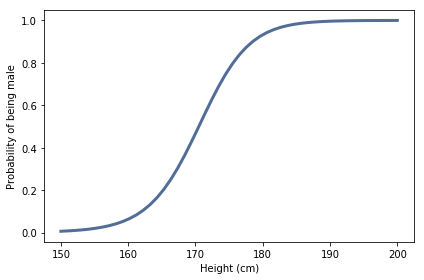

In [20]:
thinkplot.plot(prob_male)
thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='Probability of being male')

If you are curious, you can derive the mathematical form of this curve from the PDF of the normal distribution.